# Day 15 – Monte Carlo Option Pricing (European Call & Put)

Today you'll price European options using **Monte Carlo simulation** under the **risk‑neutral measure**, compare against **Black–Scholes** closed‑form prices, and estimate **Greeks** (Δ, Vega) via bump‑and‑revalue.

---

## Learning Objectives
- Simulate asset prices with **GBM** under the **risk‑neutral drift**.
- Price **European call/put** options via **Monte Carlo**.
- Validate against **Black–Scholes** closed‑form.
- Estimate **Delta** and **Vega** with **bump‑and‑revalue**.
- Inspect **convergence** as simulations increase.

## Key Concepts
- **Risk‑neutral GBM:** $ dS_t = r S_t dt + \sigma S_t dW_t $ (assuming zero dividend yield),  
  so discretely: $ S_T = S_0 \exp\{(r - \tfrac{1}{2}\sigma^2)T + \sigma \sqrt{T} Z\} $.
- **MC Price:** $ V_0 = e^{-rT} \mathbb{E}[\text{payoff}(S_T)] $.
- **Call payoff:** $ \max(S_T - K, 0) $,  **Put payoff:** $ \max(K - S_T, 0) $.
- **Delta (Δ):** Sensitivity to $S_0$.  **Vega:** Sensitivity to $\sigma$.
- **Convergence:** MC standard error $\propto 1/\sqrt{N}$.


In [1]:
import numpy as np
from scipy.stats import norm

# --- Parameters ---
S0 = 100.0     # Spot
K  = 100.0     # Strike
r  = 0.03      # Risk-free rate (annual)
sigma = 0.20   # Volatility (annual)
T = 1.0        # Time to maturity (years)
n_paths = 100_000  # Number of Monte Carlo simulations
seed = 42

np.random.seed(seed)
S0, K, r, sigma, T, n_paths

(100.0, 100.0, 0.03, 0.2, 1.0, 100000)

In [2]:
def mc_european_prices(S0, K, r, sigma, T, n_paths, option='call'):
    """Monte Carlo price for European call/put with risk-neutral GBM (single-step)."""
    Z = np.random.standard_normal(n_paths)
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    if option == 'call':
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)
    price = np.exp(-r*T) * payoff.mean()
    stderr = np.exp(-r*T) * payoff.std(ddof=1) / np.sqrt(n_paths)
    return price, stderr

def black_scholes_price(S0, K, r, sigma, T, option='call'):
    """Black–Scholes closed-form for European call/put (no dividends)."""
    if T <= 0 or sigma <= 0:
        if option == 'call':
            return max(S0 - K*np.exp(-r*T), 0.0)
        return max(K*np.exp(-r*T) - S0, 0.0)
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option == 'call':
        return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)

# Quick check (call)
mc_call, se_call = mc_european_prices(S0, K, r, sigma, T, n_paths, option='call')
bs_call = black_scholes_price(S0, K, r, sigma, T, option='call')
mc_call, se_call, bs_call

(np.float64(9.435603935142067),
 np.float64(0.044664742956132604),
 np.float64(9.413403383853016))

In [3]:
# Compare both call and put
mc_put, se_put = mc_european_prices(S0, K, r, sigma, T, n_paths, option='put')
bs_put = black_scholes_price(S0, K, r, sigma, T, option='put')

print(f"Monte Carlo Call  : {mc_call:.4f}  (SE ≈ {se_call:.4f})  | Black–Scholes Call: {bs_call:.4f}")
print(f"Monte Carlo Put   : {mc_put:.4f}  (SE ≈ {se_put:.4f})  | Black–Scholes Put : {bs_put:.4f}")

Monte Carlo Call  : 9.4356  (SE ≈ 0.0447)  | Black–Scholes Call: 9.4134
Monte Carlo Put   : 6.4421  (SE ≈ 0.0296)  | Black–Scholes Put : 6.4580


In [4]:
def bump_and_revalue_delta(S0, K, r, sigma, T, n_paths, h=1e-2, option='call'):
    """Estimate Delta = dV/dS0 using symmetric bump."""
    p_up, _ = mc_european_prices(S0*(1+h), K, r, sigma, T, n_paths, option)
    p_dn, _ = mc_european_prices(S0*(1-h), K, r, sigma, T, n_paths, option)
    return (p_up - p_dn) / (S0*(2*h))

def bump_and_revalue_vega(S0, K, r, sigma, T, n_paths, h=1e-2, option='call'):
    """Estimate Vega = dV/dsigma using symmetric bump."""
    p_up, _ = mc_european_prices(S0, K, r, sigma*(1+h), T, n_paths, option)
    p_dn, _ = mc_european_prices(S0, K, r, sigma*(1-h), T, n_paths, option)
    return (p_up - p_dn) / (sigma*(2*h))

# Compute Greeks for call
delta_mc = bump_and_revalue_delta(S0, K, r, sigma, T, 50_000, option='call')
vega_mc  = bump_and_revalue_vega(S0, K, r, sigma, T, 50_000, option='call')

# Closed-form Greeks for validation (call)
def bs_delta(S0, K, r, sigma, T, option='call'):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    if option == 'call':
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1

def bs_vega(S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return S0 * norm.pdf(d1) * np.sqrt(T)

delta_bs = bs_delta(S0, K, r, sigma, T, option='call')
vega_bs  = bs_vega(S0, K, r, sigma, T)

print(f"Delta (MC) ≈ {delta_mc:.4f} | Delta (BS) ≈ {delta_bs:.4f}")
print(f"Vega  (MC) ≈ {vega_mc:.4f}  | Vega  (BS) ≈ {vega_bs:.4f}")

Delta (MC) ≈ 0.5848 | Delta (BS) ≈ 0.5987
Vega  (MC) ≈ -7.6205  | Vega  (BS) ≈ 38.6668


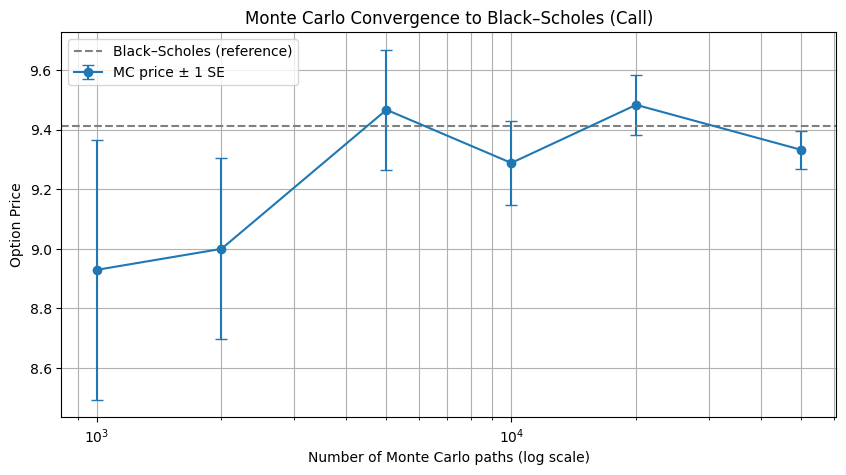

In [5]:
# Convergence: Price vs number of paths
grid = [1_000, 2_000, 5_000, 10_000, 20_000, 50_000]
mc_prices = []
mc_errs = []

for n in grid:
    price, se = mc_european_prices(S0, K, r, sigma, T, n, option='call')
    mc_prices.append(price)
    mc_errs.append(se)

import matplotlib.pyplot as plt

bs_ref = black_scholes_price(S0, K, r, sigma, T, option='call')

plt.figure(figsize=(10,5))
plt.errorbar(grid, mc_prices, yerr=mc_errs, fmt='o-', capsize=4, label='MC price ± 1 SE')
plt.axhline(bs_ref, color='gray', linestyle='--', label='Black–Scholes (reference)')
plt.xscale('log')
plt.xlabel('Number of Monte Carlo paths (log scale)')
plt.ylabel('Option Price')
plt.title('Monte Carlo Convergence to Black–Scholes (Call)')
plt.legend()
plt.grid(True, which='both')
plt.show()

## Takeaways
- Under **risk‑neutral pricing**, drift is the **risk‑free rate** $r$, not the historical return.
- Monte Carlo is flexible for complex payoffs (e.g., path‑dependent options) where closed forms don't exist.
- **Standard error** shrinks like $1/\sqrt{N}$; use variance‑reduction for efficiency in production (antithetics, control variates, QE scheme, etc.).
- **Bump‑and‑revalue** gives intuitive Greeks; for efficiency/accuracy, consider **pathwise** or **likelihood ratio** methods.

**Next steps**:  
- Add **dividends** (use drift $r - q$).  
- Price **barrier** or **Asian** options where BS has no simple closed form.  
- Implement **antithetic variates** to reduce MC variance.